# Text Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [2]:
twitter_data = pd.read_csv('training.1600000.processed.noemoticon.csv', header=None,
                           names=['sentiment','id','date','flag','user','text'], encoding='latin-1')


In [3]:
twitter_data.head()


,sentiment,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
twitter_data.shape


(1600000, 6)

In [5]:
# There is no Neutral sentiment in the dataset.
# There is no missing data for the sentiment column.
twitter_data.sentiment.value_counts()


4    800000
0    800000
Name: sentiment, dtype: int64

In [6]:
# There is no missing data for the text column.
twitter_data.text.isnull().any()


False

In [7]:
# Remove unnecessary columns from the dataset.
twitter_data.drop(['id','date','flag','user'],axis=1,inplace=True)
twitter_data.head()


,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [8]:
# Convert positive sentiments from 4 to 1
twitter_data['sentiment'][twitter_data['sentiment']==4] = 1


/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
twitter_data.sentiment.value_counts()


1    800000
0    800000
Name: sentiment, dtype: int64

In [10]:
# Take a look at the length of tweets
twitter_data['pre_clean_len'] = [len(t) for t in twitter_data.text]
twitter_data.head()


,sentiment,text,pre_clean_len
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,0,is upset that he can't update his Facebook by ...,111
2,0,@Kenichan I dived many times for the ball. Man...,89
3,0,my whole body feels itchy and like its on fire,47
4,0,"@nationwideclass no, it's not behaving at all....",111


In [11]:
print('Minimum length of pre-cleaned tweet:', twitter_data.pre_clean_len.min())


Minimum length of pre-cleaned tweet: 6


In [12]:
print('Maximum length of pre-cleaned tweet:', twitter_data.pre_clean_len.max())


Maximum length of pre-cleaned tweet: 374


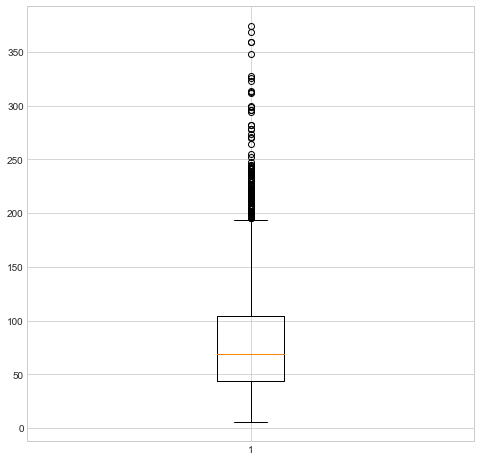

In [13]:
# Create a boxplot of tweet length
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 8))
plt.boxplot(twitter_data.pre_clean_len)
plt.show()



In [14]:
from nltk.tokenize import WordPunctTokenizer
import re
from bs4 import BeautifulSoup

token = WordPunctTokenizer()

# Removing '@mention'
pat1 = r'@[A-Za-z0-9_]+'
# Removing URL links
pat2 = r'https?://[^ ]+'
# Combine patterns
combined_pat = r'|'.join((pat1, pat2))
# Removing URL links
www_pat = r'www.[^ ]+'
# Negation dictionary
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}

neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

# data cleaning function
def tweet_cleaner(text):
    # Remove HTML codes from text
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in token.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()


In [15]:
clean_tweets = []
for i in range(len(twitter_data)):
    clean_tweets.append(tweet_cleaner(twitter_data['text'][i]))

In [16]:
clean_tweets[:10]


['awww that bummer you shoulda got david carr of third day to do it',
 'is upset that he can not update his facebook by texting it and might cry as result school today also blah',
 'dived many times for the ball managed to save the rest go out of bounds',
 'my whole body feels itchy and like its on fire',
 'no it not behaving at all mad why am here because can not see you all over there',
 'not the whole crew',
 'need hug',
 'hey long time no see yes rains bit only bit lol fine thanks how you',
 'nope they did not have it',
 'que me muera']

In [17]:
# create a dataframe with cleaned tweets
clean_data = pd.DataFrame(clean_tweets,columns=['text'])
clean_data['target'] = twitter_data.sentiment
clean_data.head()

,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [28]:
# Save the dataframe
clean_data.to_csv('clean_tweets.csv',encoding='utf-8')
# Load the clean dataset
twitter_data = pd.read_csv('clean_tweets.csv',index_col=0)
twitter_data.head()


/Applications/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [29]:
twitter_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
text      1596041 non-null object
target    1600000 non-null int64
dtypes: int64(1), object(1)
memory usage: 36.6+ MB


In [30]:
# There are null cells for text column
twitter_data.isnull().any(axis=0)


text       True
target    False
dtype: bool

In [31]:
# Which cells are null in text column
twitter_data[twitter_data.isnull().any(axis=1)].head()


,text,target
208,NaN,0
249,NaN,0
282,NaN,0
398,NaN,0
430,NaN,0


In [32]:
# Total number of null cells
np.sum(twitter_data.isnull().any(axis=1))


3959

In [33]:
# Load the original dataset
df = pd.read_csv("training.1600000.processed.noemoticon.csv",header=None, encoding='latin_1')
# See the original content of null cells before cleaning process
df.iloc[twitter_data[twitter_data.isnull().any(axis=1)].index,:].head()


,0,1,2,3,4,5
208,0,1467863072,Mon Apr 06 22:33:25 PDT 2009,NO_QUERY,Artiel87,@mandayyy
249,0,1467874569,Mon Apr 06 22:36:27 PDT 2009,NO_QUERY,Artiel87,@mandayyy
282,0,1467881474,Mon Apr 06 22:38:20 PDT 2009,NO_QUERY,__Susan__,@ITS_NEMESIS -------
398,0,1467912842,Mon Apr 06 22:46:53 PDT 2009,NO_QUERY,KimberlyKane,@danadearmond
430,0,1467919452,Mon Apr 06 22:48:48 PDT 2009,NO_QUERY,jtmal0723,@anistorm


In [34]:
# Remove rows which contain null values
twitter_data.dropna(inplace=True)
twitter_data.reset_index(drop=True,inplace=True)
twitter_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596041 entries, 0 to 1596040
Data columns (total 2 columns):
text      1596041 non-null object
target    1596041 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [38]:
# Save the dataframe
twitter_data.to_csv('clean_tweeter_data.csv',encoding='utf-8')


In [ ]:
# Word2Vec

In [116]:
# all_x = pd.concat([X_train, X_val, X_test])


In [112]:
# word2vec expects a list of lists.
# Using punkt tokenizer for better splitting of a paragraph into sentences.
import nltk.data
#nltk.download('popular')

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')


In [120]:
def review_wordlist(review, remove_stopwords=False):
    
    # Converting to lower case and splitting
    words = review.lower().split()
    # Optionally remove stopwords
    if remove_stopwords:
        stops = set(stopwords.words("english"))     
        words = [w for w in words if not w in stops]
    
    return(words)


In [121]:
# This function splits a review into sentences
def review_sentences(review, tokenizer, remove_stopwords=False):
    # 1. Using nltk tokenizer
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    # 2. Loop for each sentence
    for raw_sentence in raw_sentences:
        if len(raw_sentence)>0:
            sentences.append(review_wordlist(raw_sentence, remove_stopwords))

    # This returns the list of lists
    return sentences


In [123]:
train_sentences = []

for review in X_train:
    train_sentences += review_sentences(review, tokenizer)
    

In [125]:
from gensim.models import word2vec
w2v_model = word2vec.Word2Vec(train_sentences,
                          workers = 4, # Number of parallel threads
                          size = 300, # Word vector dimensionality
                          min_count= 2, # Minimum word count
                          window= 10, # Context window size
                          sample= 1e-3) # Downsample setting for frequent words


In [126]:
# Few tests: This will print the odd word among them 
w2v_model.wv.doesnt_match("man woman dog child kitchen".split())


'kitchen'

In [129]:
# This will print the most similar words present in the model
w2v_model.wv.most_similar("man")


[('guy', 0.5257232785224915),
 ('dude', 0.5217115879058838),
 ('boy', 0.497385174036026),
 ('woman', 0.46953463554382324),
 ('balls', 0.42327579855918884),
 ('kid', 0.41947418451309204),
 ('shit', 0.41885673999786377),
 ('fella', 0.4185824394226074),
 ('nigga', 0.41829344630241394),
 ('men', 0.4113842248916626)]

In [130]:
w2v_model.wv.most_similar("awful")


[('terrible', 0.7727991342544556),
 ('horrible', 0.7621821165084839),
 ('horrid', 0.6376410722732544),
 ('aweful', 0.6323171854019165),
 ('miserable', 0.6223897337913513),
 ('icky', 0.5958918929100037),
 ('disgusting', 0.5871309638023376),
 ('dreadful', 0.5814915895462036),
 ('rubbish', 0.5657370686531067),
 ('unpleasant', 0.5648154020309448)]

In [131]:
# This will give the total number of words in the vocabolary created from this dataset
w2v_model.wv.syn0.shape


/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


(105040, 300)

In [136]:
# Function to average all word vectors in a paragraph
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec



In [143]:
# Function for calculating the average feature vector
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        # Printing a status message every 10000th review
        if counter%100000 == 0:
            print("Review %d of %d"%(counter,len(reviews)))
            
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
        counter = counter+1
        
    return reviewFeatureVecs


In [144]:
# Calculating average feature vector for training set
clean_train_reviews = []
for review in X_train:
    clean_train_reviews.append(review_wordlist(review, remove_stopwords=False))
    
trainDataVecs = getAvgFeatureVecs(clean_train_reviews, w2v_model, num_features = 300)


Review 0 of 1564120


/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Review 100000 of 1564120
Review 200000 of 1564120
Review 300000 of 1564120
Review 400000 of 1564120
Review 500000 of 1564120
Review 600000 of 1564120
Review 700000 of 1564120
Review 800000 of 1564120
Review 900000 of 1564120
Review 1000000 of 1564120
Review 1100000 of 1564120
Review 1200000 of 1564120
Review 1300000 of 1564120
Review 1400000 of 1564120
Review 1500000 of 1564120
